# Bioinformatics 2 Project 2

**Author**: Charles Tapley Hoyt

**Partners**: Aliaksandr Masny


To convert this to a python file:

```sh
pip install jupyter
jupyter nbconvert --to python Project\ 2.ipynb --output Project\ 2.py
```

In [1]:
import time
import sys

import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
import skimage
from skimage import exposure, filters, segmentation, io
from skimage.color import rgb2gray
from sklearn import mixture
%matplotlib inline

In [3]:
print(sys.version)

3.6.0 (default, Dec 24 2016, 08:01:42) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]


In [4]:
print(time.asctime())

Sun Jan 29 17:41:40 2017


In [2]:
def ao(axes):
    for ax in axes.ravel():
        ax.axis('off')

# Assignment 6

In the first part of the second project, you will learn how to perform some simple threshold-based image analysis in Python.

Hint: If you make proper use of Python packages, none of the tasks will require you to write large amounts of code. Routines for reading and writing images can be found in the Python module scipy.misc. Other useful routines for working with images are in scipy.ndimage. You may also find routines from numpy useful for parts of your analysis. We also recommend using scikit-image library for some of the image processing functions.

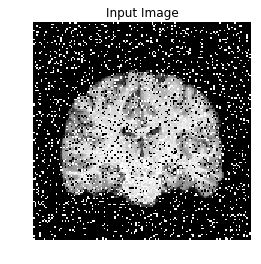

In [5]:
brain_original = io.imread('brain.png', as_grey=True)

plt.title('Input Image')
plt.imshow(brain_original, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## Assignment 6A

Read the grayscale image brain.png, which is provided on the lecture homepage. Reduce the salt and pepper noise in the image using a median filter.(3P)

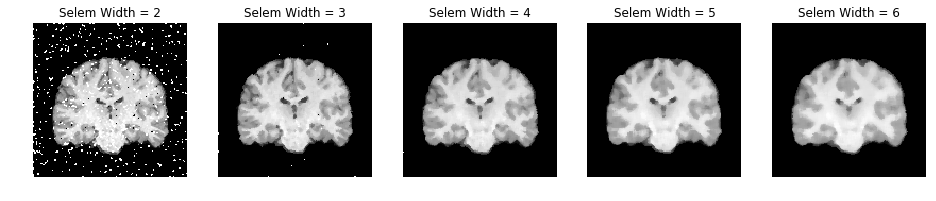

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i in range(5):
    brain_filtered = filters.median(brain_original, selem=np.ones((i + 2, i + 2)))
    axes[i].imshow(brain_filtered, cmap=plt.cm.gray)
    
    axes[i].set_title('Selem Width = {}'.format(i + 2))
    axes[i].axis('off')
    
plt.show()

### Commentary

> Using a selem width (the width of the box over which the median filter is applied) of 3 pixels maintains the best noise/sharpness, but a conservative width of 4 pixels successfully removes all noise.

## Assignment 6B

Otsu thresholding is a histogram based method for image segmentation. 

- Use it to find an intensity threshold to segment brain pixels from background.
- Use Otsu thresholding again to find the threshold only over the brain pixels to segment brain’s gray matter from the white matter.
- Using the two thresholds create three binary masks brain-bg.png, brain-gm.png, brain-wm.png, which should be white in regions of background, gray matter, and white matter, respectively, and black elsewhere. (3P)

In [10]:
brain_filtered = filters.median(brain_original, selem=np.ones((4, 4)))
brain_threshold = filters.threshold_otsu(brain_filtered)

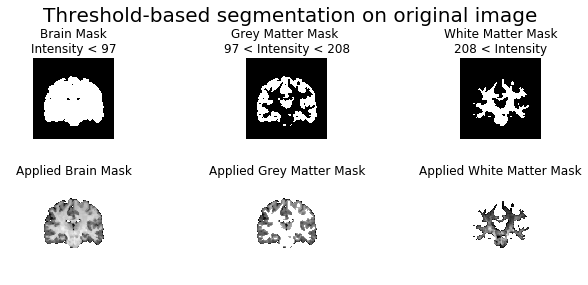

In [22]:
def calculate_brain_masks(brain_filtered):
    brain_threshold = filters.threshold_otsu(brain_filtered)
    
    bg_mask = brain_filtered < brain_threshold

    brain_only = brain_filtered.copy()
    brain_only[bg_mask] = 255
    
    white_grey_threshold = filters.threshold_otsu(brain_only)

    grey_matter_mask = brain_only < white_grey_threshold

    grey_only = brain_only.copy()
    grey_only[~grey_matter_mask] = 255

    white_only = brain_only.copy()
    white_only[grey_matter_mask] = 255
    white_matter_mask = white_only < 255
    
    return (bg_mask, brain_threshold, brain_only, 
            white_grey_threshold, grey_matter_mask, 
            grey_only, white_matter_mask, white_only)
    
def display_brain_masks(bg_mask, brain_threshold, brain_only, 
                        white_grey_threshold, grey_matter_mask, 
                        grey_only, white_matter_mask, white_only, suptitle=None):
    fig, axes = plt.subplots(2, 3, figsize=(9, 4))
    
    axes[0][0].imshow(~bg_mask, cmap='gray')
    axes[0][0].set_title('Brain Mask\nIntensity < {}'.format(brain_threshold))
    
    axes[1][0].imshow(brain_only, cmap='gray')
    axes[1][0].set_title('Applied Brain Mask')
    
    axes[0][1].imshow(grey_matter_mask, cmap='gray')
    axes[0][1].set_title('Grey Matter Mask \n{} < Intensity < {}'.format(brain_threshold, white_grey_threshold))
    
    axes[1][1].imshow(grey_only, cmap='gray')
    axes[1][1].set_title('Applied Grey Matter Mask')
    
    axes[0][2].set_title('White Matter Mask\n{} < Intensity'.format(white_grey_threshold))
    axes[0][2].imshow(white_matter_mask, cmap='gray')

    axes[1][2].imshow(white_only, cmap='gray')
    axes[1][2].set_title('Applied White Matter Mask')
    
    for ax in axes.ravel():
        ax.axis('off')
    
    plt.tight_layout()
    
    if suptitle:
        plt.suptitle(suptitle, fontsize=20)
        plt.subplots_adjust(top=0.80)
    
    
    plt.show()
    
brain_masks = calculate_brain_masks(brain_filtered)

bg_mask, brain_threshold, brain_only, white_grey_threshold, grey_matter_mask, grey_only, white_matter_mask, white_only = brain_masks

display_brain_masks(*brain_masks, suptitle='Threshold-based segmentation on original image')

## Assignment 6C

Plot a log-scaled histogram of the image, which should show how frequently different intensity values occur in the image. Mark the two intensity thresholds you found in task b). How do these thresholds divide the histogram? (4P)

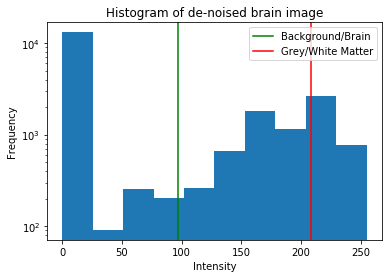

In [23]:
plt.title('Histogram of de-noised brain image')
plt.ylabel('Frequency')
plt.xlabel('Intensity')

plt.hist(brain_filtered.ravel(), log=True)
plt.axvline(brain_masks[1], color='g', label='Background/Brain')
plt.axvline(brain_masks[3], color='r', label='Grey/White Matter')
plt.legend()

plt.show()

### Answer 

> The Otsu threshold minimizes intra-cluster variance. For seperating the background from the brain, this was very easy. Seperating grey matter from white matter was a more difficult task, and it was unable to choose between two of the groupings on the above histogram.

## Assignment 6D

Combine the three masks into a single color image so that background, gray matter, and white matter are mapped to red, green and blue, respectively. (2P)

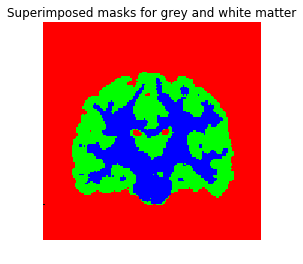

In [24]:
plt.title('Superimposed masks for grey and white matter')

rgb = (bg_mask[..., np.newaxis], grey_matter_mask[..., np.newaxis], white_matter_mask[..., np.newaxis])
combine = np.concatenate(rgb, axis=-1).astype(float)

plt.imshow(combine)
plt.axis('off')
plt.show()

## Assignment 6E

Use erosion filter to produce a boundary between the gray and white matter. Put that boundary on the denoised input image. (3P)

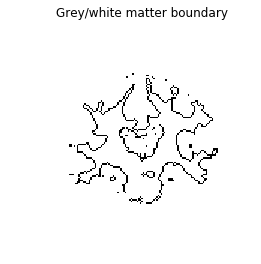

In [25]:
plt.title('Grey/white matter boundary')
plt.axis('off')
plt.imshow(90 < brain_only - skimage.morphology.erosion(grey_only) + grey_only, cmap='gray')
plt.show()

### Commentary

> Erosion turns off pixels for whom the neighborhood is not bright enough. Above is shown the a linear combination of the original image, the grey matter image, and the eroded grey matter image. It produces an outline in the shape of the grey matter/white matter boundary.

## Assignment 6F

Use bilinear interpolation to upsample the image by a factor of four along each axis. Apply the same thresholds as in b) to obtain a segmentation into background, gray matter, and white matter. Upsample the masks from b) in the same way and compare the upsampled masks to the masks from the upsampled image. Can you see a difference? Why? (4P) Repeat the same procedure using nearest neighbor interpolation. Can you see a difference now? (2P)

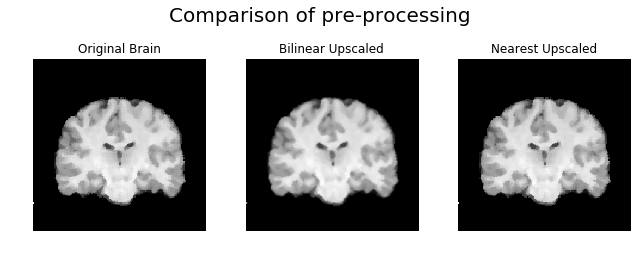

In [26]:
brain_upscaled_bilinear = scp.misc.imresize(brain_filtered, size=400, interp='bilinear')
brain_upscaled_nearest = scp.misc.imresize(brain_filtered, size=400, interp='nearest')

fig, axes = plt.subplots(1, 3, figsize=(9,4))

axes[0].set_title('Original Brain')
axes[0].imshow(brain_filtered, cmap='gray')
axes[1].set_title('Bilinear Upscaled')
axes[1].imshow(brain_upscaled_bilinear, cmap='gray')
axes[2].set_title('Nearest Upscaled')
axes[2].imshow(brain_upscaled_nearest, cmap='gray')

ao(axes)
plt.tight_layout()
plt.suptitle('Comparison of pre-processing', fontsize=20)
plt.show()

### Commentary

> The upscaled images look smoother, but it's hard to compare on matplotlib since it rescales the images to fit the same size. The "nearest" method maintains sharpness better than bilinear scaling. 

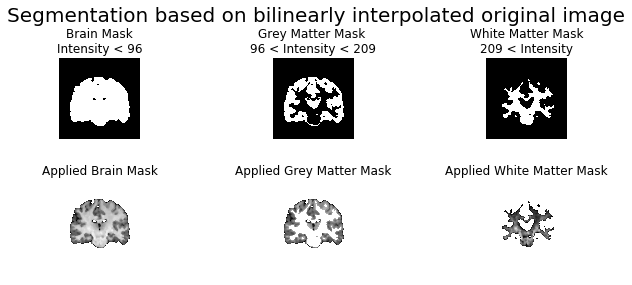

In [27]:
upscaled_bilinear_brain_masks = calculate_brain_masks(brain_upscaled_bilinear)
display_brain_masks(*upscaled_bilinear_brain_masks, suptitle='Segmentation based on bilinearly interpolated original image')

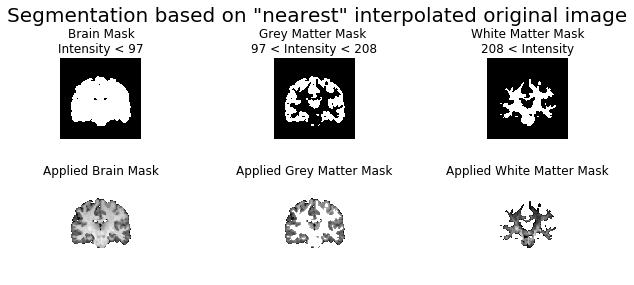

In [28]:
upscaled_nearest_brain_masks = calculate_brain_masks(brain_upscaled_nearest)
display_brain_masks(*upscaled_nearest_brain_masks, suptitle='Segmentation based on "nearest" interpolated original image')

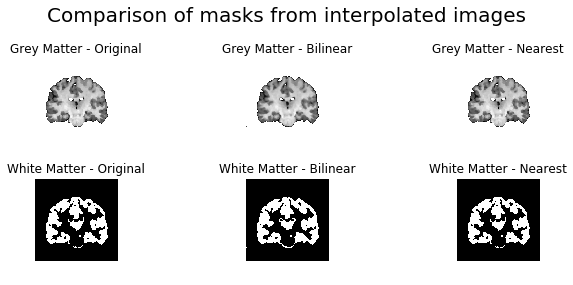

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(9,4))

axes[0][0].set_title('Grey Matter - Original')
axes[0][0].imshow(brain_masks[2], cmap='gray')
axes[0][1].set_title('Grey Matter - Bilinear')
axes[0][1].imshow(upscaled_bilinear_brain_masks[2], cmap='gray')
axes[0][2].set_title('Grey Matter - Nearest')
axes[0][2].imshow(upscaled_nearest_brain_masks[2], cmap='gray')

axes[1][0].set_title('White Matter - Original')
axes[1][0].imshow(brain_masks[4], cmap='gray')
axes[1][1].set_title('White Matter - Bilinear')
axes[1][1].imshow(upscaled_bilinear_brain_masks[4], cmap='gray')
axes[1][2].set_title('White Matter - Nearest')
axes[1][2].imshow(upscaled_nearest_brain_masks[4], cmap='gray')

ao(axes)

plt.suptitle('Comparison of masks from interpolated images', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.80)
plt.show()

### Answer 

> There is only a subtle difference in the masks produces from the interpolated original image. The masks from the bilinear interpolated image are smoother, but this is an effect of the method itself. The nearest method does not have much improvement.

In [30]:
brain_mask_upscaled_bilinear_grey = scp.misc.imresize(brain_masks[2], size=400, interp='bilinear')
brain_mask_upscaled_bilinear_white = scp.misc.imresize(brain_masks[4], size=400, interp='bilinear')

brain_mask_upscaled_nearest_grey = scp.misc.imresize(brain_masks[2], size=400, interp='nearest')
brain_mask_upscaled_nearest_white = scp.misc.imresize(brain_masks[4], size=400, interp='nearest')

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(9,4))
    
axes[0][0].set_title('Grey Matter - Original')
axes[0][0].imshow(brain_masks[2], cmap='gray')
axes[0][1].set_title('Grey Matter - Bilinear')
axes[0][1].imshow(brain_mask_upscaled_bilinear_grey, cmap='gray')
axes[0][2].set_title('Grey Matter - Nearest')
axes[0][2].imshow(brain_mask_upscaled_nearest_grey, cmap='gray')

axes[1][0].set_title('White Matter - Original')
axes[1][0].imshow(brain_masks[4], cmap='gray')
axes[1][1].set_title('White Matter - Bilinear')
axes[1][1].imshow(brain_mask_upscaled_bilinear_white, cmap='gray')
axes[1][2].set_title('White Matter - Nearest')
axes[1][2].imshow(brain_mask_upscaled_nearest_white, cmap='gray')

ao(axes)

plt.suptitle('Comparison of interpolated masks from original image', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.80)
plt.show()

### Answer

> Again, upscaling the masks calculated from the original image did not have a substantial effect. It is not noticably better than the previous processing technique.

# Assignment 7

## Assignment 7 Exercise 1

Last week, you implemented a simple thresholding-based image segmentation. This week, you will implement a Gaussian Mixture Model to produce a probabilistic segmentation, and to find suitable parameters automatically, by using the EM algorithm. Proceed in the following steps:

### Assignment 7 Exercise 1A
Load the same image brain.png and reduce the noise as in sheet 6. Produce a binary mask that marks all pixels with an intensity greater than zero. In all further steps, only treat pixels within that mask. (2P)

In [31]:
brain_mask = brain_filtered > 0
brain_only = brain_filtered.copy()
brain_only[~brain_mask] = 0

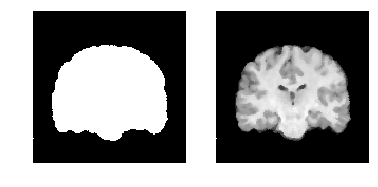

In [32]:
fig, axes = plt.subplots(1, 2)

axes[0].imshow(brain_mask, cmap='gray')
axes[0].axis('off')

axes[1].imshow(brain_only, cmap='gray')
axes[1].axis('off')

plt.show()

### Assignment 7 Exercise 1B

Initialize the parameters of a three-compartment Gaussian mixture model to some reasonable values and use them to compute the responsibilities $ρ_{i,k}$ of cluster k for pixel i. (4P)

In [33]:
# Only consider foreground pixels
X = brain_filtered[brain_filtered > 0].reshape(-1, 1)

In [34]:
# Initial values chosen by K-means clustering (built-in)
gmm = mixture.GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

### Assignment 7 Exercise 1C

Visualize the responsibilities by mapping the probabilities of belonging to the CSF, gray matter, and white matter clusters to the red, blue, and green color channels, respectively. Please submit the resulting image. (1P)

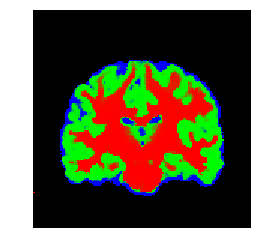

In [36]:
# Predict over all pixels
rho = gmm.predict_proba(brain_filtered.reshape((-1, 1)))

res = rho.reshape(145, 145, 3)

# Slice out background, one more time
res[~brain_mask] = 0

plt.imshow(res)
plt.axis('off')
plt.show()

### Assignment 7 Exercise 1D

Use the update rules provided in the lecture to re-compute the parameters $μ_k$, $σ_k$, and $π_k$. (4P)

In [37]:
N_k = sum(r for r in rho)
N_k

array([ 3562.00032139,  3467.49891956,   889.50075905])

In [38]:
new_mu = []
for k in range(3):
    nm = sum(a * b for a, b in zip(rho[:,k], X)) / N_k[k]
    new_mu.append(nm)
    
new_mu

[array([ 15.86831983]), array([ 42.80142323]), array([ 55.15020683])]

In [39]:
new_sig = []
for k in range(3):
    ns = sum(a * (b - new_mu[k]) for a, b in zip(rho[:,k], X)) / N_k[k]
    new_sig.append(ns)
new_sig

[array([ 14.34169002]), array([ 32.56425194]), array([ 39.52815825])]

In [40]:
new_pi = N_k / len(X)
new_pi

array([ 0.44980431,  0.43787081,  0.11232488])

### Assignment 7 Exercise 1E

Iterate the E and M steps of the algorithm until convergence. Please submit the final parameter
values, a visualization of the final responsibilities, and your code. (3P)

In [41]:
gmm.means_

array([[ 220.85135214],
       [ 167.43398597],
       [  81.92501664]])

In [42]:
gmm.covariances_

array([[[  129.46587802]],

       [[  357.41683836]],

       [[ 1164.00016653]]])

> Visualization of responsiblities is done in Exercise 1C

### Assignment 7 Exercise 1F

Create and submit a plot that illustrates the convergence of your algorithm.

In [ ]:
# Copied from https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/mixture/base.py#L171

from sklearn.mixture.base import _check_X
def fit(self, X):
        """Estimate model parameters with the EM algorithm.
        The method fit the model `n_init` times and set the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a `ConvergenceWarning` is raised.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        self
        """
        
        #ADDED FOR CONVERGENCE TRACKING
        
        track_lower_bounds = []
        track_changes = []
        
        X = _check_X(X, self.n_components)
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not(self.warm_start and hasattr(self, 'converged_'))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.infty
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)
                self.lower_bound_ = -np.infty

            for n_iter in range(self.max_iter):
                track_lower_bounds.append(self.lower_bound_)
                prev_lower_bound = self.lower_bound_

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                self.lower_bound_ = self._compute_lower_bound(log_resp, log_prob_norm)

                change = self.lower_bound_ - prev_lower_bound
                track_changes.append(change)
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(self.lower_bound_)

            if self.lower_bound_ > max_lower_bound:
                max_lower_bound = self.lower_bound_
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn('Initialization %d did not converged. '
                          'Try different init parameters, '
                          'or increase max_iter, tol '
                          'or check for degenerate data.'
                          % (init + 1), ConvergenceWarning)

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter

        return track_lower_bounds, track_changes    

In [ ]:
gmm_track = mixture.GaussianMixture(n_components=3, covariance_type='full')
lower_bounds, changes = fit(gmm_track, X)

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

axes[0].plot(lower_bounds[1:])
axes[0].set_xlabel('E/M Iterations')
axes[0].set_ylabel('Log Likelihood')

axes[1].plot(changes, label='Log Likelihood')
axes[1].set_xlabel('E/M Iterations')
axes[1].set_ylabel('Log Likelihood Change')
axes[1].axhline(gmm_track.tol, color='r', label='Tolerance')
axes[1].legend()

plt.tight_layout()
plt.show()

> This solution involved modifying the fit function provided by the sklearn GMM class to track the log likelihood change from iteration to iteration. The algorithm stops when the log likelihood is below a certain tolerance, which defaults to 0.001. This is illustrated on the plot to the right.

## Assignment 7 Exercise 2 (Updating $σ_k$ in the EM Algorithm, 4 Points)

Derive the update rule for $σ_k$ that is performed in the M-step of the EM algorithm:

$\sigma^2_k = \frac{\sum^n_{i=1}\rho_{i,k}(x_i-\mu_k)^2}{N_k}$
     
Hint: The derivation is very similar to the one for μk, which was shown in the lecture.

Given: 

$\ln p(X | \pi, \mu, \sigma) = \sum_{i=1}^n \ln \sum^K_{l=1} \pi_lN(x_i|\mu_l,\sigma^2_l)$

$\frac{\partial \ln p}{\partial \sigma_k} = $

## Assignment 7 Exercise 3 (Convergence of K-means, 4 Points)

The EM algorithm can be considered as an extension of K-means. Is the K-means algorithm guaranteed to converge after a finite number of steps? If so, why? Does your answer depend on the exact way in which collapsing clusters are detected and treated?

> K-means clustering is most commonly implemented with the gradient descent algorithm and the distortion function as the cost function. Depending on the relation between the step size and the steepness of the local minima, it might oscillate. Practical solutions, such as dampening factors, tolerances, and step count limits have been implemented to surpass this theoretical limitaion. It is also not guaranteed to converge at a global minimum. Methods like consensus clustering have been developed that try and mitigate the effects of random starting cluster positions have on the results. 

# Assignment 8

- In order to do the following tasks please read the explanation.pdf, which is provided on the lecture homepage.

## Assignment 8B

Load the same noisy image brain.png, and download the mask.png from the lecture homepage. Based on your implementation of the EM algorithm from sheet 7, create a discrete (hard / non- probabilistic) label image that contains the most likely material for each pixel. Output it as an RGB image. For the segmentation use the mask.png in order to apply the algorithms only on the foreground pixels. (3P)

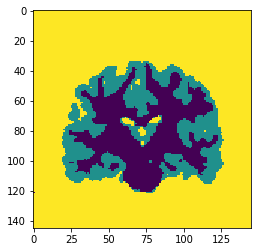

In [130]:
hard_assignments = gmm.predict(brain_filtered.reshape((-1, 1)))

res = hard_assignments.reshape(145, 145)

plt.imshow(res)
plt.show()

> The GMM implementation in sklearn automatically assigns classes based on the highest probability for each pixel

## Assignment 8C

Implement one iteration of the Iterated Conditional Modes (ICM) algorithm (for a Markov Random Field that uses the Potts model and β = 0.5) and use it to update the label image. Output the result as an RGB image. (5P)

In [116]:
import itertools as itt

def iterate_icm(mat, nlabels, mask, alpha=2, beta=0.5):
    ls, ws = mat.shape
    
    res = np.zeros(mat.shape)
    
    def valid_loc(x, y):
        return 0 <= x < ls and 0 <= y < ws and mask[x, y]
        
    
    for l, w in itt.product(range(ls), range(ws)):
        if not valid_loc(l, w):
            continue
        
        no = l + 1, w
        so = l - 1, w
        ea = l, w + 1
        we = l, w - 1
        
        neighbors = [(a, b) for a, b in [no, so, ea, we] if valid_loc(a, b)]
        
        scores = {}
        for label in range(nlabels):
            
            internal_energy = alpha * (label != mat[l, w])       
            external_energy = beta * sum(label != mat[a, b] for a, b in neighbors)
                     
            scores[label] = internal_energy + external_energy
        
        res[l,w] = min(scores, key=scores.get)
   
        
    return res

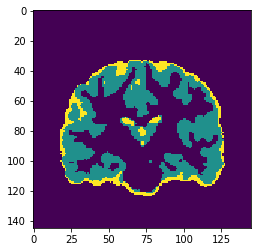

In [124]:
plt.imshow(iterate_icm(res, 3, brain_mask))
plt.show()

## Assignment 8D

Apply your ICM iteration five times overall. Output the number of pixels whose label changes in each iteration, and output the final labels as an RGB image. (3P)

In [139]:
def calc_diff(mat1, mat2, mask):
    assert mat1.shape == mat2.shape
    ls, ws = mat1.shape
    
    def valid_loc(x, y):
        return 0 <= x < ls and 0 <= y < ws and mask[x, y]
    
    delta = 0
    
    for i, j in itt.product(range(ls), range(ws)):
        if not valid_loc(i,j):
            continue
        
        if mat1[i,j] != mat2[i,j]:
            delta += 1
            
    return delta

In [143]:
def run_icm(res, nlabels, mask, iterations=4, alpha=2, beta=0.5):
    r = iterate_icm(res, nlabels, mask, alpha, beta)
        
    if iterations == 0:
        return [(r, None)]
    
    r2 = run_icm(r, nlabels, mask, iterations - 1, alpha, beta)
    
    return [(res, calc_diff(res, r, mask))] + r2

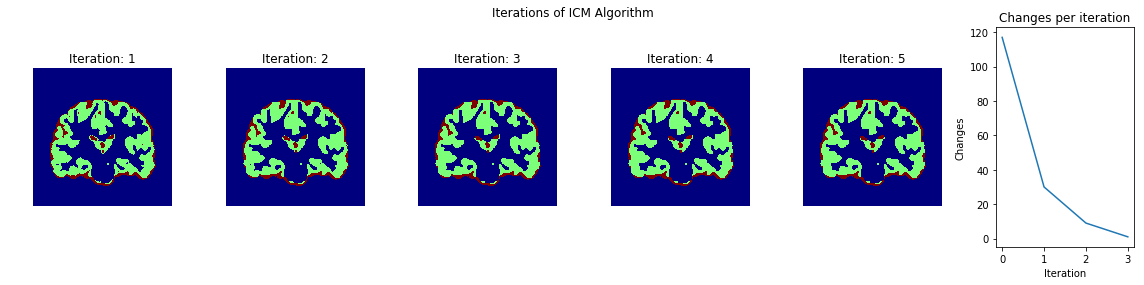

In [147]:
x = run_icm(res, 3, brain_mask, alpha=0.5)

mats, changes = list(zip(*x))

fix, axes = plt.subplots(1, len(mats) + 1, figsize=(16,4))

for i, (f, ax) in enumerate(zip(mats, axes.ravel()), start=1):
    
    f[~brain_mask] = 0
    
    ax.imshow(f, cmap='jet')
    ax.set_title('Iteration: {}'.format(i))
    ax.axis('off')

axes[-1].plot(changes)
axes[-1].set_title('Changes per iteration')
axes[-1].set_xlabel('Iteration')
axes[-1].set_ylabel('Changes')

plt.suptitle('Iterations of ICM Algorithm')
plt.tight_layout()
plt.show()

## Assignment 8E
Integrate your implementation of the ICM into the EM algorithm and run it until convergence. Output the final result as an RGB image. (6P)

In [ ]:
# Copied from https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/mixture/base.py#L171

from sklearn.mixture.base import _check_X
def fit_with_icm(self, X):
        """Estimate model parameters with the EM algorithm.
        The method fit the model `n_init` times and set the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a `ConvergenceWarning` is raised.
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        self
        """
        
        #ADDED FOR CONVERGENCE TRACKING
        
        track_lower_bounds = []
        track_changes = []
        
        X = _check_X(X, self.n_components)
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not(self.warm_start and hasattr(self, 'converged_'))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.infty
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)
                self.lower_bound_ = -np.infty

            for n_iter in range(self.max_iter):
                track_lower_bounds.append(self.lower_bound_)
                prev_lower_bound = self.lower_bound_

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                self.lower_bound_ = self._compute_lower_bound(log_resp, log_prob_norm)

                change = self.lower_bound_ - prev_lower_bound
                track_changes.append(change)
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(self.lower_bound_)

            if self.lower_bound_ > max_lower_bound:
                max_lower_bound = self.lower_bound_
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn('Initialization %d did not converged. '
                          'Try different init parameters, '
                          'or increase max_iter, tol '
                          'or check for degenerate data.'
                          % (init + 1), ConvergenceWarning)

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter

        return track_lower_bounds, track_changes  

## Assignment 8F

Increase the β parameter and repeat task e). At which value of β is the final segmentation almost noise-free similar to Fig. 1 right? Output the final result. (3P)

## Assignment 8G

Compare the output from task f) to the result of segmentation using GMM. How do the segmentation images differ and how would you explain the difference? (2P)

## Assignment 8H

So far, given the different methods for image segmentation, when would you choose a) Threshold based segmentation b) GMM c) MRF for segmenting a given image? (3P)

> The MRF is the best method because it takes spatial orientation into account. Threshold based and GMM based methods only use the histogram, and are highly susceptible to noise.

## Assignment 9 Exercise 1 (Threshold-Free Cluster Enhancement, 10 Points)

In this exercise, you will implement a 2D version of the Threshold-Free Cluster Enhancement (TFCE) algorithm and apply it to the statistical parametric map in spm.npy which you can download from the lecture webpage. The 2D map can be seen as an image with a t score at each pixel. Since t scores are signed floating-point numbers, we store it in numpy’s .npy format rather than in a traditional image format.

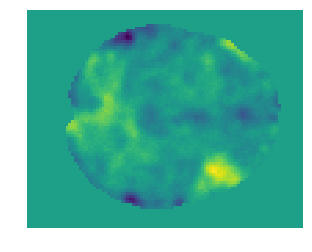

In [279]:
spm = np.load('spm.npy')

plt.imshow(spm)
plt.axis('off')
plt.show()

### Assignment 9 Exercise 1A

Write a function that, for any given threshold value, creates a binary mask and a label image. Labeling means that you should assign a unique identifier to each connected component of the mask. In the label image, the value of each pixel should be the identifier of the component it belongs to. Feel free to make use of the functionality in scipy.ndimage. (3P)

In [ ]:
# see: http://www.scipy-lectures.org/advanced/image_processing/#id14
from skimage import measure
from scipy import ndimage

def make_mask(img, threshold):
    mask = img > threshold
    label_im, nb_labels = ndimage.label(mask)
    return mask, label_im, nb_labels

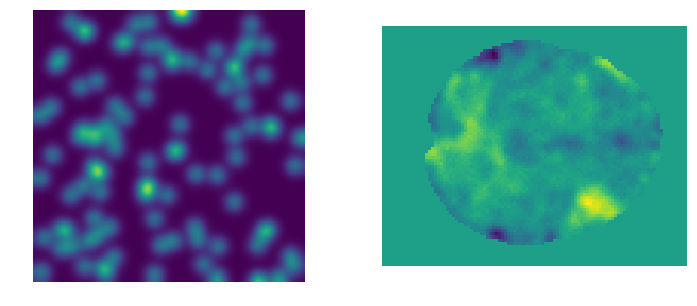

In [287]:
# Make sample data
n = 10
l = 256
im = np.zeros((l, l))
points = l * np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

fix, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(im)
axes[1].imshow(spm)
ao(axes)
plt.show()

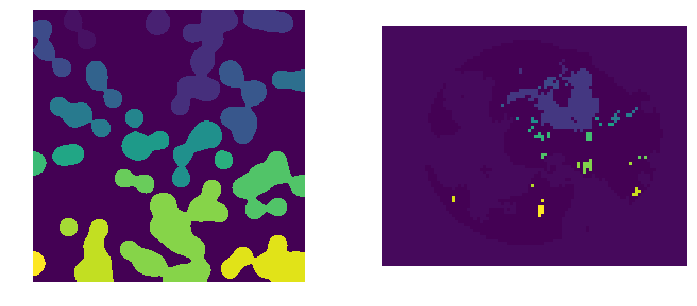

In [286]:
im_mask, im_label_im, im_nb_labels = make_mask(im, im.mean())
spm_mask, spm_label_im, spm_nb_labels = make_mask(spm, spm.mean())

fix, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(im_label_im)
axes[1].imshow(spm_label_im)
ao(axes)
plt.show()

### Assignment 9 Exercise 1B

Write a function that, given the label image, creates an extent image which, for each pixel, should contain the extent (i.e., size in number of pixels) of the component it belongs to. (3P)

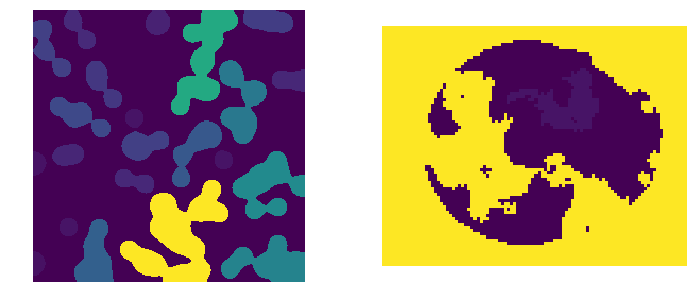

In [288]:
def make_extent(mask, label_im, nb_labels):
    extents = ndimage.sum(mask, label_im, range(nb_labels + 1))

    ref = dict(zip(range(nb_labels + 1), extents))
    
    #return ref
    n = np.zeros(mask.shape)
    for i, j in itt.product(range(mask.shape[0]), range(mask.shape[1])):
        n[i,j] = ref[label_im[i, j]]
    return n
    
im_extent = make_extent(im_mask, im_label_im, im_nb_labels)
spm_extent = make_extent(spm_mask, spm_label_im, spm_nb_labels)

fix, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(im_extent)
axes[1].imshow(spm_extent)
ao(axes)
plt.show()

### Assignment 9 Exercise 1C

Write a loop that iterates over a given number of threshold values (between 0 and the maximum found in the input) and, for each pixel p, performs numerical integration of the TFCE integral, with the commonly used values $E=0.5$ and $H=2$

$TFCE(p)=\int_{h=0}^{h_p} e(h)^Eh^H dh$ 

In [275]:
def tfce(img, max_threshold, E=0.5, H=2, n_steps=None):
    
    if max_threshold > img.max():
        print('Max threshold above img.max: {}'.format(img.max()))
        max_threshold = img.max()
    
    sums = np.zeros(img.shape)
    
    num = max_threshold if n_steps is None else n_steps
    
    ls = np.linspace(0, stop=max_threshold, num=num)
    
    for threshold in ls:
        
        mask, label_im, nb_labels = make_mask(img, threshold)
        extent = make_extent(mask, label_im, nb_labels)
        sums += extent ** E * threshold ** H
    
    return sums

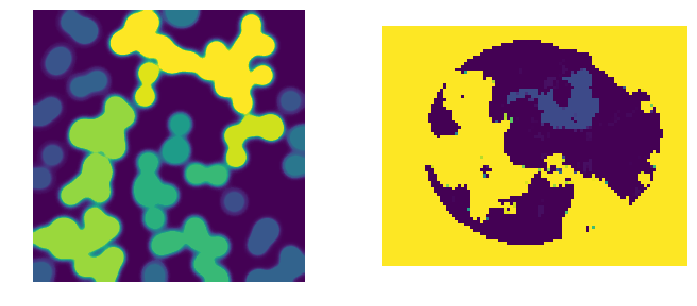

In [295]:
im_tfce = tfce(im, im.mean(), n_steps=50)
spm_tfce = tfce(spm, spm.mean(), n_steps=50)

fix, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(im_tfce)
axes[1].imshow(spm_tfce)
ao(axes)
plt.show()

### Assignment 9 Exercise 1C

Try different step sizes for the discretization of the integral (i.e., different number of threshold
TFCE(p) =
with the commonly used values E = 0.5, H = 2. (3P)
values). How does the resulting image change? (1P)
Please submit your script and the TFCE-transformed input for at least two different discretizations.

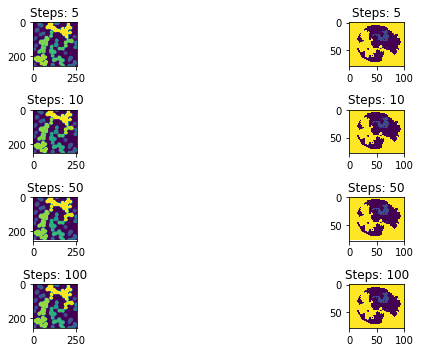

In [299]:
step_sizes = [5, 10, 50, 100]

fix, axes = plt.subplots(len(step_sizes), 2, figsize=(12, 15))

for i, n_steps in enumerate(step_sizes):
    axes[i][0].imshow(tfce(im, im.mean(), n_steps=n_steps))
    axes[i][0].set_title('Steps: {}'.format(n_steps))
    axes[i][1].imshow(tfce(spm, spm.mean(), n_steps=n_steps))
    axes[i][1].set_title('Steps: {}'.format(n_steps))
    
plt.tight_layout()
plt.show()

## Assignment 9 Exercise 2 (Hemodynamic Response Function, 6 Points)


### Assignment 9 Exercise 2A

Sample the “doubleg gamma” canonical hemodynamic response function at 0.1s temporal resolution and plot it. (2P)
Hint: You can make use of the gamma distribution available in scipy.

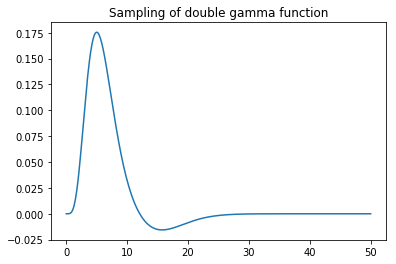

In [364]:
from scipy.stats import gamma

def dg(x, a1=6, a2=16, c=(-1/6)):
    return gamma.pdf(x, a1) + c*gamma.pdf(x, a2)

plt.title('Sampling of double gamma function')
l = 50
x = np.linspace(0, l, int(l / 0.1))
plt.plot(x, dg(x))
plt.show()

### Assignment 9 Exercise 2B

Using the result from a), predict the response to two box-shaped stimuli, which should have unit magnitude and 1s or 2s duration, respectively. Perform the required computations numerically at 0.1 s temporal resolution, and plot the results. (2P)
Hint: You can make use of the methods for convolution available in numpy.
h=0

In [365]:
stimulus_duration = 2 # second
stimulus = [1 for _ in range(int(stimulus_duration / 0.1))]
response = np.array([0] * int(4 / 0.1) + stimulus + [0] * int(44 / 0.1))
len(response), len(x)

(500, 500)

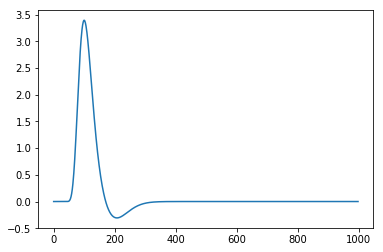

In [354]:
plt.plot(np.convolve(response, dg(x)))
plt.show()

## Assignment 8 Exercise 2C

Downsample your results from b) to the 2.5s temporal resolution that is more typical of fMRI. Also perform the convolution at 2.5 s resolution and compare the results. (2P)

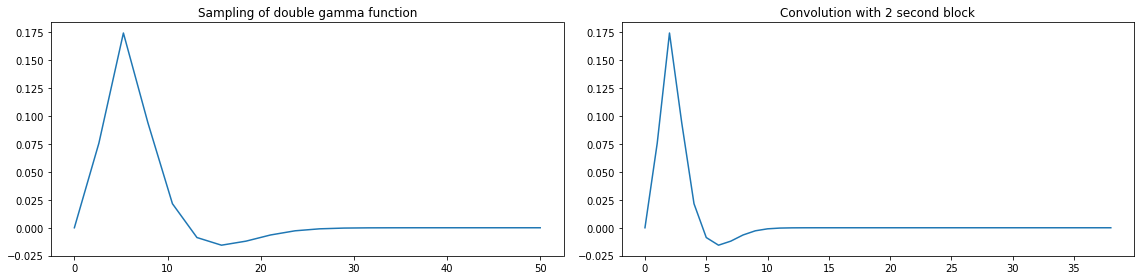

In [376]:
l = 50
x = np.linspace(0, l, int(l / 2.5))
stimulus_duration = 2 # second
stimulus = [1 for _ in range(int(stimulus_duration / 2.5))]
response = np.array([1] + [0] * int(48 / 2.5))

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].set_title('Sampling of double gamma function')
axes[0].plot(x, dg(x))

axes[1].plot(np.convolve(response, dg(x)))
axes[1].set_title('Convolution with 2 second block')

plt.tight_layout()
plt.show()

> The poor temporal resolution made the calculation of the maxima and minima in the double gamma function much more error-prone. 

## Assignment 9 Exercise 3 (General Linear Model, 9 Points)

### Assignment 9 Exercise 3A

In the following diagram, which line is the best linear regression for the given data points? Why? Which line is the worst? (3P)


> h2 is the best linear regression becuase it has the least sum of square errors. h3 could also be a good model, because it has an intercept of zero, and is therefore a much simpler model. h1 is clearly the worst, because it has significantly issues with explaining the variability of data

### Assignment 9 Exercise 3B

Given the following data set: (x1,i , x2,i , yi ) : {(2, 5, 2), (1, 4, 7), (3, 1, 11), (4, 2, 4)}

1. Write down the corresponding matrix X. (2P)
2. Use GLM to compute the β vector. (4P)

In [351]:
X = [[2, 5], [1, 4], [3, 1], [4, 2]]
y = [2, 7, 11, 4]

In [352]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [353]:
reg.coef_

array([-3., -3.])